In [1]:
from nltk.corpus import wordnet as wn
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

Using TensorFlow backend.
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\gulja\python 3.7.3\lib\site-packages\tensorflow\python\framewo

In [2]:
df_data=pd.read_csv('labels.csv')
events= pd.read_csv('eventsummary.csv')

In [3]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t,m) for w, p, t,m in zip(s["Words"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist(),
                                                           s["Tag2"].values.tolist())]
        self.grouped = self.data.groupby("event_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
words = set(df_data["Words"].values.tolist())


In [5]:
getter = SentenceGetter(df_data)

# Get sentence data
sentences1 = [[s[0] for s in sent] for sent in getter.sentences]
sentences1[0]
sentences = getter.sentences
# # Get tag labels data
# labels = [[s[2] for s in sent] for sent in getter.sentences]
# print(labels[0])

In [6]:
sentences1 = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences1[0]

'A shooting takes place at  a  pub  in  Tel Aviv Israel leaving two dead  and  eight injured gunman managed to escape possibly killed his accomplice an Arab taxi driver whose body was found nearby police identified shooter  as  30 year old muslim Nisaat Melkham from Arara searched home'

In [7]:
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'arg', 'O', 'arg', 'arg', 'arg', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [8]:
word_tokenizer = Tokenizer()
print(word_tokenizer.fit_on_texts(sentences1))
vocab_length = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(sentences1)


None


In [9]:
from nltk.tokenize import word_tokenize

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(sentences1, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

print(length_long_sentence)

258


In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences1], bins=10)
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
X=padded_sentences
max_len=length_long_sentence
# words = set(df["Words"].values.tolist())
# # words.append("ENDPAD")
# n_words = len(words); 
tags = set(df_data["Tag"].values.tolist())
n_tags = len(tags); 
tags2 = set(df_data["Tag2"].values.tolist())
n_tags2 = len(tags2); 
pos= set(df_data["Tag2"].values.tolist())
n_pos = len(pos); 
sent = getter.get_next()
# word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)} #vocab for tags arguments
tag22idx = {t: i for i, t in enumerate(tags2)} #vocab for tags relation
tagpos = {t: i for i, t in enumerate(pos)} #vocab for tags relation

# from keras.preprocessing.sequence import pad_sequences
# X = [[word2idx[w[0]] for w in s] for s in sentences]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)


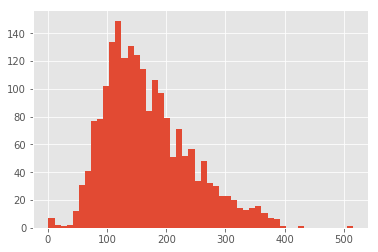

In [12]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences1], bins=50)
plt.show()

In [13]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]
#.....................output 2 label Relations..........................
y1 = [[tag22idx[w[3]] for w in s] for s in sentences]
y1 = pad_sequences(maxlen=max_len, sequences=y1, padding="post", value=tag22idx["O"])
y1 = [to_categorical(i, num_classes=n_tags2) for i in y1]
# print(y)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('C:/Users/gulja/Python 3.7.3/Scripts/thesis/2020/Word Embeddings/glove.6B.100d.txt', encoding="utf8")


In [15]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [16]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
len(X)

2018

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
X_tr, X_te, y_tr, y_te,y1_tr, y1_te = train_test_split(X,y, y1, test_size=0.2)

In [20]:
vocab_length

9791

In [21]:
from keras import optimizers
input = Input(shape=(max_len,))
model = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=length_long_sentence)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="sigmoid"))(model)  # softmax output layer
out1 = TimeDistributed(Dense(n_tags2, activation="sigmoid"))(model) 
model = Model(input, [out,out1])
adam1 = optimizers.adam(lr=0.01)
model.compile(optimizer=adam1,loss="binary_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
from keras.utils.vis_utils import plot_model

In [23]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# What I did are followed:
model.summary()
import keras
import pydot_ng as pydot
pydot.find_graphviz()
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 258)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 258, 100)     979100      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 258, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 258, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________________
time_distr

In [24]:
history = model.fit(X_tr, [np.array(y_tr),np.array(y1_tr)], batch_size=32, epochs=5, validation_split=0.2, verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 1291 samples, validate on 323 samples
Epoch 1/5
1291/1291 [==============================] - 22s 17ms/step - loss: 0.1551 - time_distributed_1_loss: 0.0907 - time_distributed_2_loss: 0.0644 - time_distributed_1_acc: 0.9695 - time_distributed_1_f1_m: 0.9611 - time_distributed_1_precision_m: 0.9715 - time_distributed_1_recall_m: 0.9595 - time_distributed_2_acc: 0.9798 - time_distributed_2_f1_m: 0.9726 - time_distributed_2_precision_m: 0.9762 - time_distributed_2_recall_m: 0.9714 - val_loss: 0.0622 - val_time_distributed_1_loss: 0.0417 - val_time_distributed_2_loss: 0.0205 - val_time_distributed_1_acc: 0.9813 - val_time_distributed_1_f1_m: 0.9813 - val_time_distributed_1_precision_m: 0.9806 - val_time_distributed_1_recall_m: 0.9820 - val_time_distributed_2_acc: 0.9938 - val_time_distributed_2_f1_m: 0.9938 - val_time_distributed_2_precision_m: 0.9938 - val_time_distributed_2_recall_m: 0.9938
Epoch 2/5
1291/1291 [=====================

In [25]:
hist = pd.DataFrame(history.history)


dict_keys(['val_loss', 'val_time_distributed_1_loss', 'val_time_distributed_2_loss', 'val_time_distributed_1_acc', 'val_time_distributed_1_f1_m', 'val_time_distributed_1_precision_m', 'val_time_distributed_1_recall_m', 'val_time_distributed_2_acc', 'val_time_distributed_2_f1_m', 'val_time_distributed_2_precision_m', 'val_time_distributed_2_recall_m', 'loss', 'time_distributed_1_loss', 'time_distributed_2_loss', 'time_distributed_1_acc', 'time_distributed_1_f1_m', 'time_distributed_1_precision_m', 'time_distributed_1_recall_m', 'time_distributed_2_acc', 'time_distributed_2_f1_m', 'time_distributed_2_precision_m', 'time_distributed_2_recall_m'])


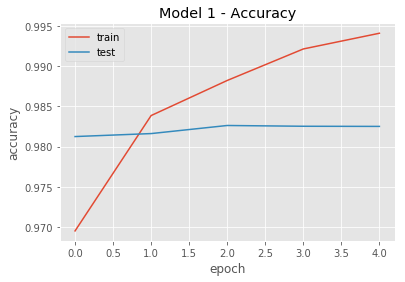

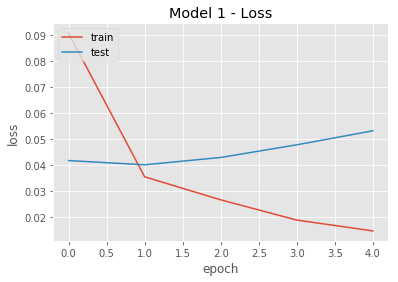

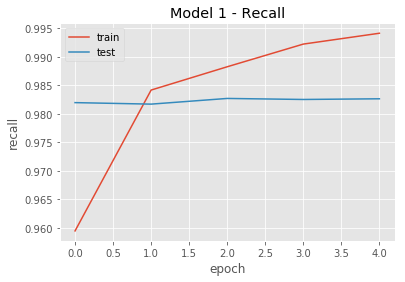

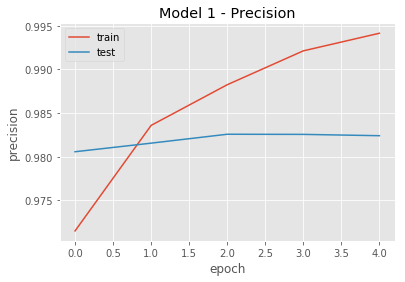

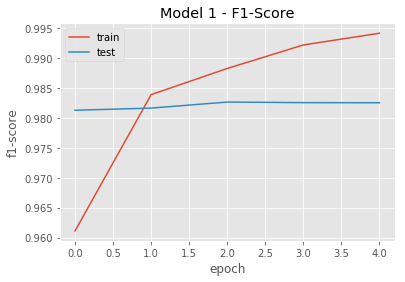

In [26]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['time_distributed_1_acc'])
plt.plot(history.history['val_time_distributed_1_acc'])
plt.title('Model 1 - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# ............................................................
plt.plot(history.history['time_distributed_1_loss'])
plt.plot(history.history['val_time_distributed_1_loss'])
plt.title('Model 1 - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ............................................................
plt.plot(history.history['time_distributed_1_recall_m'])
plt.plot(history.history['val_time_distributed_1_recall_m'])
plt.title('Model 1 - Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ............................................................
plt.plot(history.history['time_distributed_1_precision_m'])
plt.plot(history.history['val_time_distributed_1_precision_m'])
plt.title('Model 1 - Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# ............................................................
plt.plot(history.history['time_distributed_1_f1_m'])
plt.plot(history.history['val_time_distributed_1_f1_m'])
plt.title('Model 1 - F1-Score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


dict_keys(['val_loss', 'val_time_distributed_1_loss', 'val_time_distributed_2_loss', 'val_time_distributed_1_acc', 'val_time_distributed_1_f1_m', 'val_time_distributed_1_precision_m', 'val_time_distributed_1_recall_m', 'val_time_distributed_2_acc', 'val_time_distributed_2_f1_m', 'val_time_distributed_2_precision_m', 'val_time_distributed_2_recall_m', 'loss', 'time_distributed_1_loss', 'time_distributed_2_loss', 'time_distributed_1_acc', 'time_distributed_1_f1_m', 'time_distributed_1_precision_m', 'time_distributed_1_recall_m', 'time_distributed_2_acc', 'time_distributed_2_f1_m', 'time_distributed_2_precision_m', 'time_distributed_2_recall_m'])


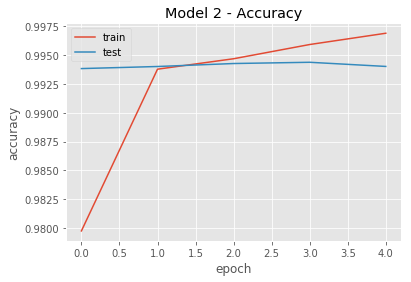

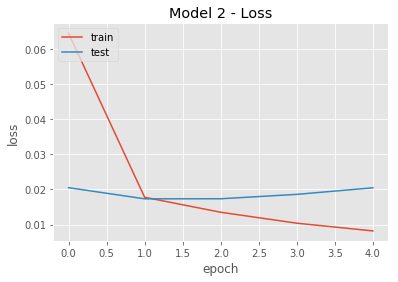

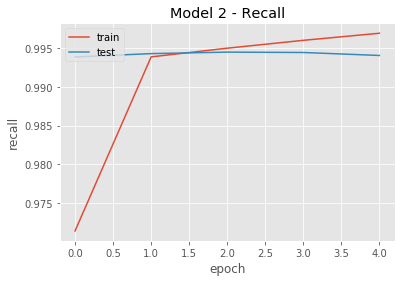

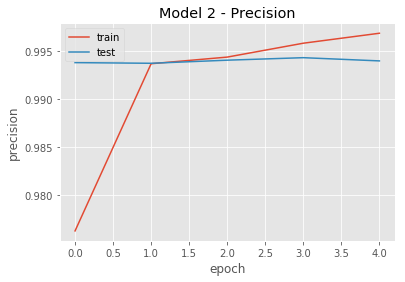

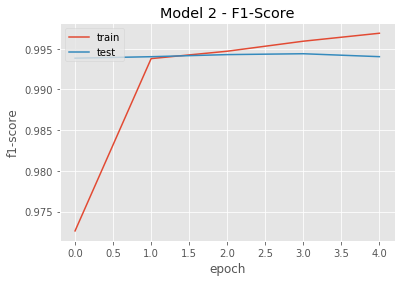

In [27]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['time_distributed_2_acc'])
plt.plot(history.history['val_time_distributed_2_acc'])
plt.title('Model 2 - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# ............................................................
plt.plot(history.history['time_distributed_2_loss'])
plt.plot(history.history['val_time_distributed_2_loss'])
plt.title('Model 2 - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ............................................................
plt.plot(history.history['time_distributed_2_recall_m'])
plt.plot(history.history['val_time_distributed_2_recall_m'])
plt.title('Model 2 - Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ............................................................
plt.plot(history.history['time_distributed_2_precision_m'])
plt.plot(history.history['val_time_distributed_2_precision_m'])
plt.title('Model 2 - Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# ............................................................
plt.plot(history.history['time_distributed_2_f1_m'])
plt.plot(history.history['val_time_distributed_2_f1_m'])
plt.title('Model 2 - F1-Score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [28]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [29]:
test_pred = model.predict(X_te, verbose=1)

404/404 [==============================] - 2s 4ms/step


In [30]:
# test_pred1 = model.predict(X_te, verbose=1)

In [31]:
# test_pred = np.argmax(test_pred, axis=-1)

In [32]:
# test_pred[0][0]

In [33]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
# pred_labels = pred2label(test_pred)
test_labels1 = pred2label(y_te)
test_labels2 = pred2label(y1_te)

In [34]:
idx2tag = {i: w for w, i in tag2idx.items()}
idx2tag2 = {i: w for w, i in tag22idx.items()}


def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
def pred2label2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag2[p_i])
        out.append(out_i)
    return out
    
pred_labels1 = pred2label(test_pred[0])
pred_labels2 = pred2label2(test_pred[1])
test_labels1 = pred2label(y_te)
test_labels2 = pred2label2(y1_te)

In [35]:
# test_pred[0]

In [36]:
print("1: F1-score: {:.1%}".format(f1_score(test_labels1, pred_labels1)))
print("2: F1-score: {:.1%}".format(f1_score(test_labels2, pred_labels2)))


1: F1-score: 28.0%
2: F1-score: 33.1%


In [37]:
print(classification_report(test_labels1, pred_labels1))
print(classification_report(test_labels2, pred_labels2))


           precision    recall  f1-score   support

      arg       0.30      0.26      0.28       826

micro avg       0.30      0.26      0.28       826
macro avg       0.30      0.26      0.28       826

           precision    recall  f1-score   support

 relation       0.43      0.27      0.33       453

micro avg       0.43      0.27      0.33       453
macro avg       0.43      0.27      0.33       453



In [38]:
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_labels1,pred_labels1)
print(cm)

ValueError: multiclass-multioutput is not supported

In [ ]:
i = 101
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print('.....................................................................................')
# print(p[0][0])
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred,pred1 in zip(X_te[i], p[0][0], p[1][0]):
    print("{}    {}".format(list(tags)[pred],list(tags2)[pred1]))
print('.....................................................................................')    
# # print(p[1][0])
# for w, pred1 in zip(X_te[i], p[1][0]):
#     print("{}".format( list(tags2)[pred1]))

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_class)
print(cm)